In [1]:
# Importing Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

# DATA PREPROCESSING

## DATA CLEANING PIPLINE

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def data_cleaning_pipline(data, is_test_data=False):
    # General step
    clean_step_1 = data.drop(['id', 'clean_title'], axis=1)

    if not is_test_data:
        print("TRAIN DATA CLEANING PIPLINE...")
        num_columns = clean_step_1.select_dtypes(include=np.number).columns
        cat_columns = clean_step_1.select_dtypes(exclude=np.number).columns
        imputer = ColumnTransformer([
            ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_columns),
            ('num_imputer', SimpleImputer(strategy='median'), num_columns)
        ], remainder='drop')
        clean_step_2 = pd.DataFrame(imputer.fit_transform(clean_step_1), columns=[*cat_columns, *num_columns])
        # Ensure numerical columns are converted back to their original types
        clean_step_2[num_columns] = clean_step_2[num_columns].apply(pd.to_numeric, errors='coerce')

        print("Missing Values Imputed...")

        # Detecting And Removing Outliers From Data
        outliers = pd.DataFrame() # An empty dataframe
        for feature in num_columns:
            q1, q3 = clean_step_2[feature].quantile(0.25), clean_step_2[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers_instances = clean_step_2[(clean_step_2[feature] < lower_bound) | (clean_step_2[feature] > upper_bound)]
            outliers = pd.concat([outliers, outliers_instances]).drop_duplicates()
            print(f"FEATURE: {feature}, NUM OF OUTLIERS: {len(outliers_instances)}")
        clean_step_2 = clean_step_2.drop(outliers.index)
        print(f"TOTAL OUTLIERS REMOVED: {len(outliers)}")

        iso_forest = IsolationForest(contamination=0.19, random_state=42)
        predictions = iso_forest.fit_predict(clean_step_2[num_columns])
        # Outliers are marked as -1
        outliers = clean_step_2[predictions == -1]
        clean_step_2 = clean_step_2.drop(outliers.index)

        # Removing weird symbols from the dataset
        clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]
        print("Removed Weird Symbols")

        return clean_train

    if is_test_data:
        print("TEST DATA CLEANING PIPLINE...")
        num_columns = clean_step_1.select_dtypes(include=np.number).columns
        cat_columns = clean_step_1.select_dtypes(exclude=np.number).columns
        imputer = ColumnTransformer([
            ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_columns),
            ('num_imputer', SimpleImputer(strategy='median'), num_columns)
        ], remainder='drop')
        clean_step_2 = pd.DataFrame(imputer.fit_transform(clean_step_1), columns=[*cat_columns, *num_columns])
        # Ensure numerical columns are converted back to their original types
        clean_step_2[num_columns] = clean_step_2[num_columns].apply(pd.to_numeric, errors='coerce')
        print("Missing Values Imputed...")

        # Removing weird symbols from the dataset
        clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]
        print("Removed Weird Symbols")

        return clean_train


cleaned_train = data_cleaning_pipline(train, is_test_data=False)
cleaned_test = data_cleaning_pipline(test, is_test_data=True)

TRAIN DATA CLEANING PIPLINE...
Missing Values Imputed...
FEATURE: model_year, NUM OF OUTLIERS: 5132
FEATURE: milage, NUM OF OUTLIERS: 1766
FEATURE: price, NUM OF OUTLIERS: 10880
TOTAL OUTLIERS REMOVED: 17326


C:\Users\deusm\AppData\Local\Temp\ipykernel_19120\766837012.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]


Removed Weird Symbols
TEST DATA CLEANING PIPLINE...
Missing Values Imputed...


C:\Users\deusm\AppData\Local\Temp\ipykernel_19120\766837012.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]


Removed Weird Symbols


## IDENTIFYING HIGH CARDINALITY CATEGORICAL VARIABLES

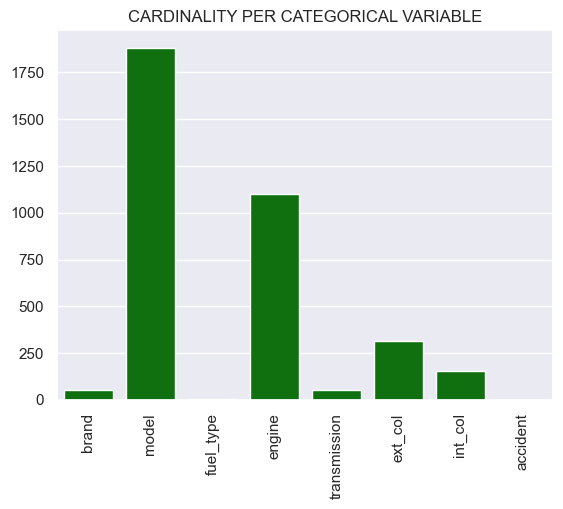

In [4]:
# Cardinality- Number of unique data per feature or categorical variable
sns.barplot(cleaned_train.select_dtypes(exclude=np.number).nunique(), color='green')
plt.xticks(rotation=90)
plt.title('CARDINALITY PER CATEGORICAL VARIABLE')
plt.show()

In [5]:
# COMBINING LESS FREQUENT CATEGORIES TOGETHER
def combiner(train_data, test_data, categorical_features, threshold, stats=None, drop_original=None):
    """A function that combines less frequent features
    whose normalized frequency is less than the threshold
    in categorical variables"""
    for feature in categorical_features:
        print(">> " + feature.upper())
        print(f'train_CARDINALITY BEFORE: {train_data[feature].nunique()}')
        print(f'test_CARDINALITY BEFORE: {test_data[feature].nunique()}')
        cat_freq = train_data[feature].value_counts(normalize=True)
        cat_to_keep = cat_freq[cat_freq >= threshold].index
        train_data[feature + '_group'] = train_data[feature].where(train_data[feature].isin(cat_to_keep), 'Other')
        test_data[feature + '_group'] = test_data[feature].where(test_data[feature].isin(cat_to_keep), 'Other')
        print(f'train_CARDINALITY AFTER: {train_data[feature + "_group"].nunique()}')
        print(f'train_CARDINALITY AFTER: {test_data[feature + "_group"].nunique()}')
        if stats:
            print('\n\n')
            print(cat_freq)
        if drop_original:
            train_data = train_data.drop([feature], axis=1)
            test_data = test_data.drop([feature], axis=1)
    return train_data, test_data

In [6]:
cleaned_train1, cleaned_test1 = combiner(train_data=cleaned_train,
                                         test_data=cleaned_test,
                                         categorical_features=cleaned_train.select_dtypes(exclude=np.number).columns,
                                         threshold=0.01, drop_original=True)

>> BRAND
train_CARDINALITY BEFORE: 55
test_CARDINALITY BEFORE: 55
train_CARDINALITY AFTER: 25
train_CARDINALITY AFTER: 25
>> MODEL
train_CARDINALITY BEFORE: 1881
test_CARDINALITY BEFORE: 1888
train_CARDINALITY AFTER: 3
train_CARDINALITY AFTER: 3
>> FUEL_TYPE
train_CARDINALITY BEFORE: 6
test_CARDINALITY BEFORE: 6
train_CARDINALITY AFTER: 5
train_CARDINALITY AFTER: 5
>> ENGINE
train_CARDINALITY BEFORE: 1102
test_CARDINALITY BEFORE: 1116
train_CARDINALITY AFTER: 15
train_CARDINALITY AFTER: 15
>> TRANSMISSION
train_CARDINALITY BEFORE: 51
test_CARDINALITY BEFORE: 51
train_CARDINALITY AFTER: 16
train_CARDINALITY AFTER: 16
>> EXT_COL
train_CARDINALITY BEFORE: 316
test_CARDINALITY BEFORE: 316
train_CARDINALITY AFTER: 7
train_CARDINALITY AFTER: 7
>> INT_COL
train_CARDINALITY BEFORE: 155
test_CARDINALITY BEFORE: 155
train_CARDINALITY AFTER: 9
train_CARDINALITY AFTER: 9
>> ACCIDENT
train_CARDINALITY BEFORE: 2
test_CARDINALITY BEFORE: 2
train_CARDINALITY AFTER: 2
train_CARDINALITY AFTER: 2


In [7]:
cleaned_train1.head()

,model_year,milage,price,brand_group,model_group,fuel_type_group,engine_group,transmission_group,ext_col_group,int_col_group,accident_group
3,2017.0,19500.0,45000.0,Other,Other,Gasoline,Other,Transmission w/Dual Shift Mode,Black,Black,None reported
6,2016.0,62200.0,28500.0,Audi,Other,Gasoline,Other,8-Speed A/T,Black,Black,None reported
7,2016.0,102604.0,12500.0,Chevrolet,Other,E85 Flex Fuel,Other,A/T,White,Gray,None reported
8,2020.0,38352.0,62890.0,Ford,F-150 XLT,Gasoline,Other,10-Speed Automatic,Other,Black,None reported
9,2015.0,74850.0,4000.0,BMW,Other,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Other,None reported


# DATA TRANSFORMATION PIPELINE

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# # Convert model_year To String
# train['model_year'] = train['model_year'].astype(str)


num_features = ['model_year', 'milage']

transformer = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False), cleaned_train1.select_dtypes(exclude=np.number).columns),
    ('num', StandardScaler(), num_features)
], remainder='drop')


In [9]:
# TRANSFORMING THE WHOLE DATASET
transformed_train = transformer.fit_transform(cleaned_train1)
transformed_test = transformer.fit_transform(cleaned_test1)

# PREDICTIVE MODELS AND DIMENSIONALITY REDUCTION

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline


def dim_selector(algorithm, n_dims_to_try, X, y, return_barplot=None):
    """A Function That Compares Model Performance With The Number Of Feature Dimension
    Using Singular Value Decomposition Method Due To its Robustness With Sparse Data"""
    models = dict()
    model_scores = dict()

    for component in range(1, n_dims_to_try):
        model = Pipeline([
            ('lda', TruncatedSVD(n_components=component)),
            ('model', algorithm)
        ])
        models['model_' + str(component) + 'c'] = model

    for name, model in models.items():
        cv_ = KFold(n_splits=4)
        scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv_, n_jobs=-1)
        model_scores[name] = np.mean(-scores)

    if return_barplot:
        sns.barplot(model_scores, color='green')
        plt.title("Model Accuracies With Number Of Components")
        plt.xticks(rotation=90)
        plt.ylabel("rmse")
        plt.xlabel("model trained on n features")
        plt.show()
    else:
        return model_scores



## X, y

In [12]:
X_train, y_train  = transformed_train, cleaned_train['price'].values

### CROSS VALIDATION FUNCTION

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# CROSS VALIDATION FUNCTION
def cross_validator(algorithm, xtrain, ytrain, n_components, cv):
    """A cross-validation function for comparing models train with
    dimensionality reduction and without"""

    print("MODEL RMSE SCORES")
    scores = cross_val_score(algorithm, xtrain, ytrain,
                             scoring='neg_root_mean_squared_error',
                             cv=cv, n_jobs=-1)
    print(-scores)
    print("\nMODEL RMSE SCORES WITH DIMENSIONALITY REDUCTION")
    model_with_dim = Pipeline([
        ('dim_reduction', TruncatedSVD(n_components=n_components)),
        ('model', algorithm)
    ])
    scores_1 = cross_val_score(model_with_dim, xtrain, ytrain,
                             scoring='neg_root_mean_squared_error',
                             cv=cv, n_jobs=-1)
    print(-scores_1)

    # Conclusions
    if np.mean(scores_1) > np.mean(scores):
        print("Model Performed Better With Dim Reduction")
    else:
        print("Model Performed Better Without Dim Reduction")


## MODEL SELECTION EXPERIMENTS

In [14]:
from xgboost import XGBRegressor
cross_validator(algorithm=XGBRegressor(), xtrain=X_train,
                ytrain=y_train, n_components=84, cv=4)

MODEL RMSE SCORES
[10567.40734729 10551.04279503 10631.50938255 10569.76763754]

MODEL RMSE SCORES WITH DIMENSIONALITY REDUCTION
[10811.44798009 10749.37674783 10828.96574668 10791.11845639]
Model Performed Better Without Dim Reduction


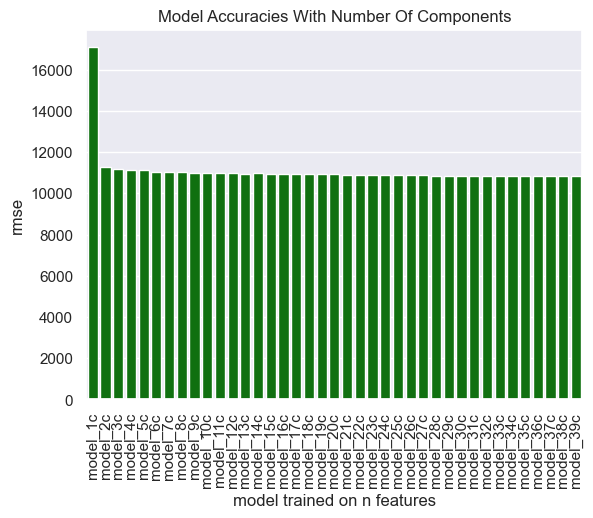

In [16]:
# WITH DIMENSIONALITY REDUCTION
dim_selector(algorithm=XGBRegressor(), n_dims_to_try=40, X=X_train, y=y_train, return_barplot=True)

In [17]:
# AN ENSEMBLE OF XGBOOST REGRESSORS
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

e_regressor = BaggingRegressor(
    SVR(kernel='poly'),
    n_estimators=5,
    max_samples=5000, n_jobs=-1
)

cross_validator(e_regressor, xtrain=X_train, ytrain=y_train, n_components=40 ,cv=4)

MODEL RMSE SCORES
[17400.17768785 17338.19886283 17368.08697519 17403.46434145]

MODEL RMSE SCORES WITH DIMENSIONALITY REDUCTION
[17391.20555108 17373.66181026 17392.9302139  17408.59317281]
Model Performed Better Without Dim Reduction


In [18]:
# TRAIN XGB
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# PREDICTING PRICES
prediction = xgb_model.predict(transformed_test)
prediction

array([19974.74 , 47384.83 , 44596.11 , ..., 19352.87 , 16568.836,
       33668.58 ], dtype=float32)